In [8]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline
sys.path.append('..')
from zwatershed import *
from visualization.visualize_funcs import *
from edgelist_methods import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'
from multiprocessing import Pool

# -------------------------------- parameters ---------------------------------------
gt_seg = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
gt_aff = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_aff.h5'
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
# pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'

out_folder = '/nobackup/turaga/singhc/par_zwshed/'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 16
MAX_LEN = 200

# -------------------------------- load data ---------------------------------------
f = h5py.File(pred_file, 'r')
preds = np.array(f['main']).astype('float32')
g = h5py.File(gt_seg,'r')
gt_seg = g['main']
print preds.shape

(3, 432, 432, 432)


# Divide Volumes, set up args

In [9]:
def dim_to_name(start):
    return str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'_vl1/'
dims = np.array(preds.shape[1:])
print "dims",dims # x,y,z
num_vols = np.array([int(x/MAX_LEN)+1 for x in dims])
# num_vols[0] = 2 # delete this!
deltas = dims/num_vols
print "num_vols",num_vols
print "deltas",deltas
starts,ends = [],[]
for x in range(num_vols[0]):
    for y in range(num_vols[1]):
        for z in range(num_vols[2]):
            starts.append((x,y,z)*deltas)
            extra = 3*np.array([x==num_vols[0]-1,y==num_vols[1]-1,z==num_vols[2]-1],dtype='int')
            ends.append((x,y,z)*deltas + deltas + [1,1,1]+extra)
args = []
for i in range(len(starts)):
    s,e = starts[i],ends[i]
    pred_vol = preds[:,s[0]:e[0],s[1]:e[1],s[2]:e[2]]
    print i,s,e,pred_vol.shape
    args.append((pred_vol,threshes,out_folder+dim_to_name(s)))    

dims [432 432 432]
num_vols [3 3 3]
deltas [144 144 144]
0 [0 0 0] [145 145 145] (3, 145, 145, 145)
1 [  0   0 144] [145 145 289] (3, 145, 145, 145)
2 [  0   0 288] [145 145 436] (3, 145, 145, 144)
3 [  0 144   0] [145 289 145] (3, 145, 145, 145)
4 [  0 144 144] [145 289 289] (3, 145, 145, 145)
5 [  0 144 288] [145 289 436] (3, 145, 145, 144)
6 [  0 288   0] [145 436 145] (3, 145, 144, 145)
7 [  0 288 144] [145 436 289] (3, 145, 144, 145)
8 [  0 288 288] [145 436 436] (3, 145, 144, 144)
9 [144   0   0] [289 145 145] (3, 145, 145, 145)
10 [144   0 144] [289 145 289] (3, 145, 145, 145)
11 [144   0 288] [289 145 436] (3, 145, 145, 144)
12 [144 144   0] [289 289 145] (3, 145, 145, 145)
13 [144 144 144] [289 289 289] (3, 145, 145, 145)
14 [144 144 288] [289 289 436] (3, 145, 145, 144)
15 [144 288   0] [289 436 145] (3, 145, 144, 145)
16 [144 288 144] [289 436 289] (3, 145, 144, 145)
17 [144 288 288] [289 436 436] (3, 145, 144, 144)
18 [288   0   0] [436 145 145] (3, 144, 145, 145)
19 [288  

# Call Watershed

In [147]:
def zwshed_h5_par(arg):
    (pred_vol,threshes,seg_save_path) = arg
    zwatershed_h5(pred_vol, threshes,seg_save_path)
    print "finished",seg_save_path,"watershed"
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)
# zwshed_h5_par(args[0])

finished /nobackup/turaga/singhc/par_zwshed/0_0_0_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_0_144_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_0_288_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_144_0_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_144_144_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_144_288_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_0_0_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_0_288_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_288_288_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_144_0_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_0_144_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_144_144_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/144_144_288_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_288_0_vl1/ watershed
finished /nobackup/turaga/singhc/par_zwshed/

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Stitch

i,x,y,z 1 0 0 1
edge_mins [0 0 0 ..., 0 0 0]
edge_maxes [ 2  2  2 ..., 20 20 20]
len re_z 0
renums {}
counts {}
len counts 0
	merging numbers, 0 keys ... 
renums filtered {}
	before nsegs= 615 num0= 6076108
	after nsegs= 615 num0= 6076108
	renumbering all... 615 num0= 

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


6076108

STARTING Y

renums {}
counts {}
len counts 0
	merging numbers, 0 keys ... 
renums filtered {}
	before nsegs= 615 num0= 24053788
	after nsegs= 615 num0= 24053788


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


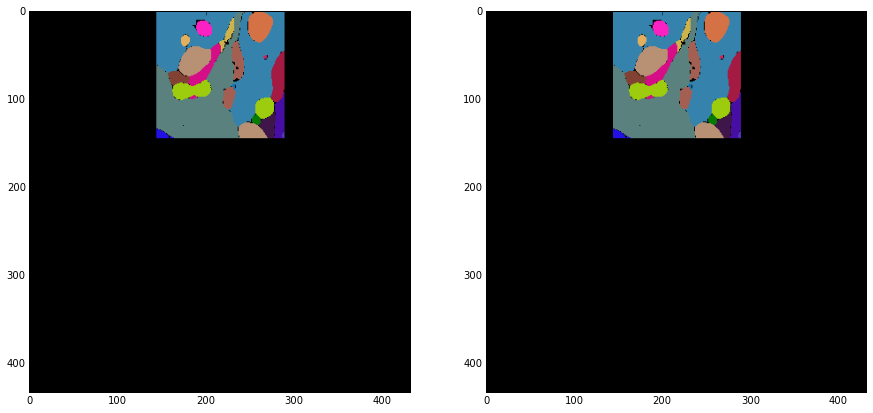

	renumbering all... 616 num0= 24053788
i,x,y,z 4 0 1 1
edge_mins [0 0 0 ..., 0 0 0]
edge_maxes [ 2  2  2 ..., 57 57 57]
len re_z 0
renums {}
counts {}
len counts 0
	merging numbers, 0 keys ... 
renums filtered {}
	before nsegs= 934 num0= 6084928
	after nsegs= 934 num0= 6084928
	renumbering all... 

In [ ]:
# todo - have this support several threshes - for filename in os.listdir(arg[2]):
COUNT_THRESH = 1
filename = 'seg_2000.h5'
i = 0
seg_out = np.zeros(dims,dtype='uint64')
re_x = {}
for x in range(1): #num_vols[0]):
    i = x*num_vols[1]*num_vols[2]
    sx,ex = starts[i],ends[i]
    
    # start ybar --------------------------------------------------
    xdim = deltas[0]+1
    if x==num_vols[0]-1:
        xdim = dims[0]-deltas[0]*(num_vols[0]-1)
    ybar = np.zeros((xdim,dims[1],dims[2]),dtype='uint64')
    re_y = {}
    for y in range(0,2): #num_vols[1]):
        i = x*num_vols[1]*num_vols[2]+y*num_vols[2]
        sy,ey = starts[i], ends[i]
        
        # start zbar -----------------------------------------------
        ydim = deltas[1]+1
        if y==num_vols[1]-1:
            ydim = dims[1]-deltas[1]*(num_vols[1]-1)
        zbar = np.zeros((xdim,ydim,dims[2]),dtype='uint64')
        re_z = {} # maxes -> mins
        counts = {}
        for z in range(1,2): #num_vols[2]): 
            i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
            arg,s,e = args[i],starts[i],ends[i]
            seg = np.array(h5py.File(arg[2]+filename,'r')['main'])
            seg[seg!=0]+=np.max(zbar)+1
            print "i,x,y,z",i,x,y,z
            if z==0: 
                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
            else:         
                re_z = calc_renums(edge_mins=zbar[:,:,s[2]],edge_maxes=seg[:,:,0], re=re_z)
                print "len re_z",len(re_z)
                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
            zbar = merge_and_renum(re_z,zbar,inc=False,p=False)
        zbar[zbar!=0] += np.max(ybar)+1
        # end zbar --------------------------------------------------
        print "\nSTARTING Y\n"
        counts = {}
        if y==0: # don't merge
            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]
        else: # merge
            re_y = calc_renums(edge_mins=ybar[0:,s[1],:],edge_maxes=zbar[0:,0,:], re=re_y)
            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]

        ybar = merge_and_renum(re_y,ybar,inc=False,p=True)
    ybar[ybar!=0] += np.max(seg_out)+1
    # end ybar -------------------------------------------------------
    
'''
    if x==0: # don't merge
        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]
    else: # merge
        re_x = calc_renums(edge_mins=seg_out[sx[0],:,:],edge_maxes=ybar[0,:,:],re=re_x)
        seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]
seg_out = merge_and_renum(re_x,seg_out,inc=False,p=False)
print "finished"
# display_seg_xy(seg_out)
'''

In [69]:
# stitch methods
def calc_renums(edge_mins,edge_maxes, re):
    edge_mins = edge_mins.ravel()
    edge_maxes = edge_maxes.ravel()
    print "edge_mins",edge_mins
    print "edge_maxes",edge_maxes
    for j in range(len(edge_mins)):
        edge_min = edge_mins[j]
        edge_max = edge_maxes[j]
        if not edge_min==0 and not edge_max==0:
            if not edge_max==edge_min:
                if edge_max in re: # already in map
                    old_min = re[edge_max]
                    merge_max = max(old_min,edge_min)
                    merge_min = min(old_min,edge_min)
                    if not merge_max==merge_min:
                        re[merge_max] = merge_min
                        add_or_inc(merge_max,merge_min,counts)
            re[edge_max] = edge_min
            add_or_inc(edge_max,edge_min,counts)
    return re
    
def prune_and_renum(seg,sizeThreshold=1):
    segId = np.unique(seg)
    renum = np.zeros(segId.max()+1,dtype='uint64')
    renum[segId] = np.arange(1,len(segId)+1)
    renum[0] = 0
    seg = renum[seg]
    return seg

def add_or_inc(key_max,key_min,d):
    key = (key_max,key_min)
    if not key in d:
        d[key] = 1
    else:
        d[key] +=1
    
def merge_and_renum(renums,zbar,inc=True,p=False):
    # only keep strongest edges
    renums = {}
    count_maxes = {}
    for pair in counts:
        count = counts[pair]
        e1,e2 = pair
        if e1 in renums:
            if count > count_maxes[e1]:
                renums[e1] = e2
                count_maxes[e1] = count
        else:
            renums[e1] = e2
            count_maxes[e1] = count
            
            
    
    
    # merge numbers
    print "renums",renums
    print "counts",counts
    print "len counts",len(counts)
    sum_counts = 0
    for key in counts:
        sum_counts += counts[key]
#     print "ave counts",float(sum_counts) / len(counts)
#     print "counts",counts
#     print "renums",renums
    renums2 = {}
    print "\tmerging numbers,",len(renums.keys()),"keys ... "            
    for key in renums:
        val = renums[key]
        if counts[(key,val)] > COUNT_THRESH:
            while val in renums:
                val = renums[val]
            renums2[key] = val
    print "renums filtered",renums2
            
    print "\tbefore nsegs=",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        fig = plt.figure(figsize=(15, 7))
        plt.subplot(1,2,1)
        plt.imshow(zbar[0, :, :], cmap=cmap)
    
    mp = np.arange(0,np.max(zbar)+1,dtype='uint64')
    mp[renums2.keys()] = renums2.values()
    zbar = mp[zbar]
    print "\tafter nsegs=",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        plt.subplot(1,2,2)
        plt.imshow(zbar[0, :, :], cmap=cmap)
    plt.show()
    
    # renumber all
    print "\trenumbering all...",np.max(zbar),"num0=",np.sum(zbar==0)
    zbar = prune_and_renum(zbar,2)
#     if p:
#         plt.imshow(zbar[1, :, :], cmap=cmap)
#     plt.show()
#     print "\tend all...",np.max(zbar),"num0=",np.sum(zbar==0)
    if inc:
        zbar[zbar!=0] += np.max(zbar)+1
    return zbar

# Visualize

In [138]:
def display_affs(raw):
    plt.imshow(np.transpose(raw[:, :, :, 1],(2,1,0)))
    plt.show()
def display_seg_yz(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(raw[depth, :, :], cmap=cmap)
    plt.show()
def display_seg_xy(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[:, :, depth], cmap=cmap)
    plt.show()

(3, 125, 300, 300)
preds0
0.999997
0.000641769
0.734931
1.0
0.058145
0.860175
1.0
0.124801
0.86506
(125, 300, 300, 3)
(125, 313, 314)


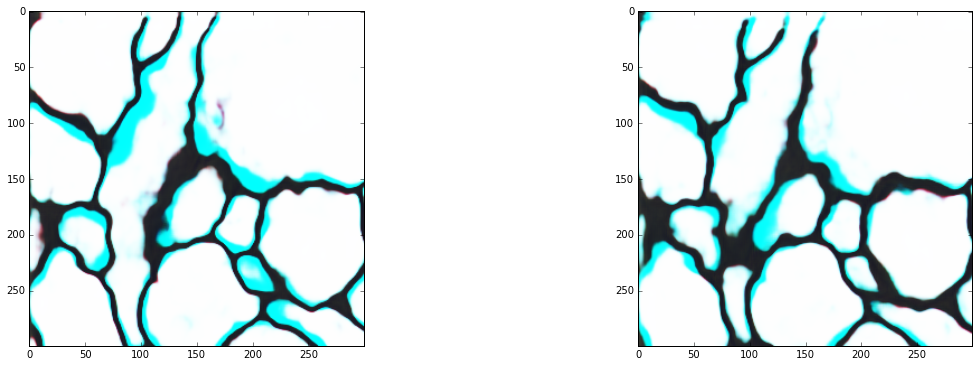

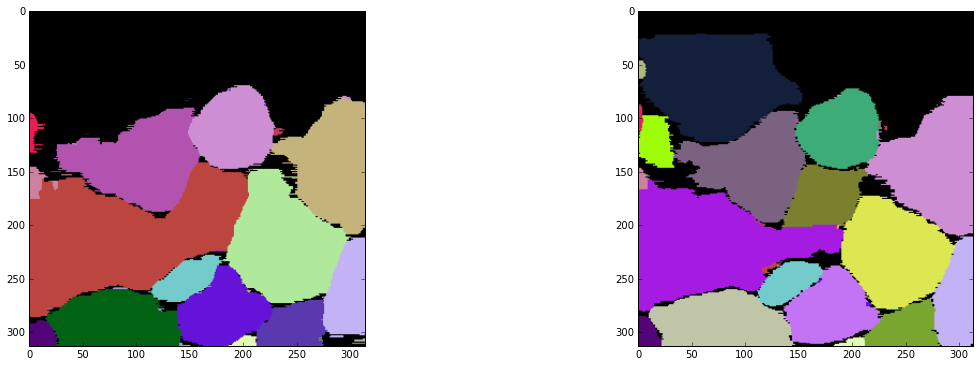

In [27]:
# display_affs(preds,preds,preds)
p_small = preds[:300,:300,:300,:300]
print p_small.shape
preds0 = p_small[0,:,:,:]
print "preds0"
print np.max(preds0)
print np.min(preds0)
print np.average(preds0)
preds1 = p_small[1,:,:,:]
print np.max(preds1)
print np.min(preds1)
print np.average(preds1)
preds2 = p_small[2,:,:,:]
print np.max(preds2)
print np.min(preds2)
print np.average(preds2)
raw = np.transpose(p_small,(1,2,3,0))
print raw.shape
# seg = zwatershed(p_small,[2000])[0]
print seg.shape
fig = plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.imshow(raw[50, :, :, :])
plt.subplot(1,2,2)
plt.imshow(raw[51, :, :, :])
plt.show()
fig = plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.imshow(seg[50, :, :],cmap=cmap)
plt.subplot(1,2,2)
plt.imshow(seg[51, :, :],cmap=cmap)
plt.show()